In [13]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import root_mean_squared_error, r2_score
from category_encoders.count import CountEncoder

df = pd.DataFrame(
    fetch_california_housing().data, columns=fetch_california_housing().feature_names
)
df["MedHouseVal"] = fetch_california_housing().target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [14]:
df.isnull().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

model = LinearRegression()

X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

In [16]:
def get_one_hot(X, cols):
    for each in cols:
        dummies = pd.get_dummies(X[each], prefix=each)
        X = pd.concat([X, dummies], axis=1)
    return X


def get_count(X, cols):
    X = X.copy()
    for each in cols:
        X[each] = X[each].astype("str")
    ce = CountEncoder(handle_unknown=-1)
    ce.fit(X[cols])
    X[cols] = ce.transform(X[cols])
    return X

In [17]:
def get_metrics(X, y, model=None):
    if model is None:
        model = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {"rmse": rmse, "r2": r2}

In [18]:
metrics = get_metrics(X, y)
print(metrics["rmse"])
print(metrics["r2"])

0.7455813830127763
0.575787706032451


Постройте график распределения целевой переменной. Сделайте вывод. Присутствуют ли в этом признаке выбросы?

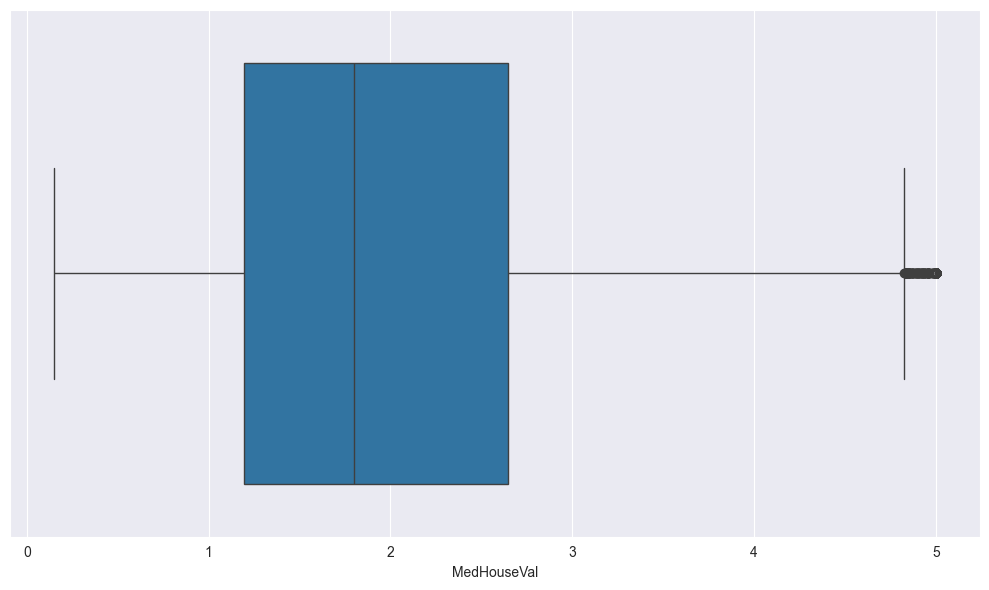

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=y)
plt.tight_layout()
plt.show()

Судя по графику целевой переменной - технически выбросы присутствуют, но их плотное скопление у верхней границы нормального значения без существенного отдаления указывает на то, что данные значения вряд ли являются реальными выбросами. Мы их будем применять в модели.

Посчитайте и выведите корреляционную матрицу. Убедитесь, что ячейки матрицы поделены на цветные категории, в ячейках указано числовое значение корреляции.

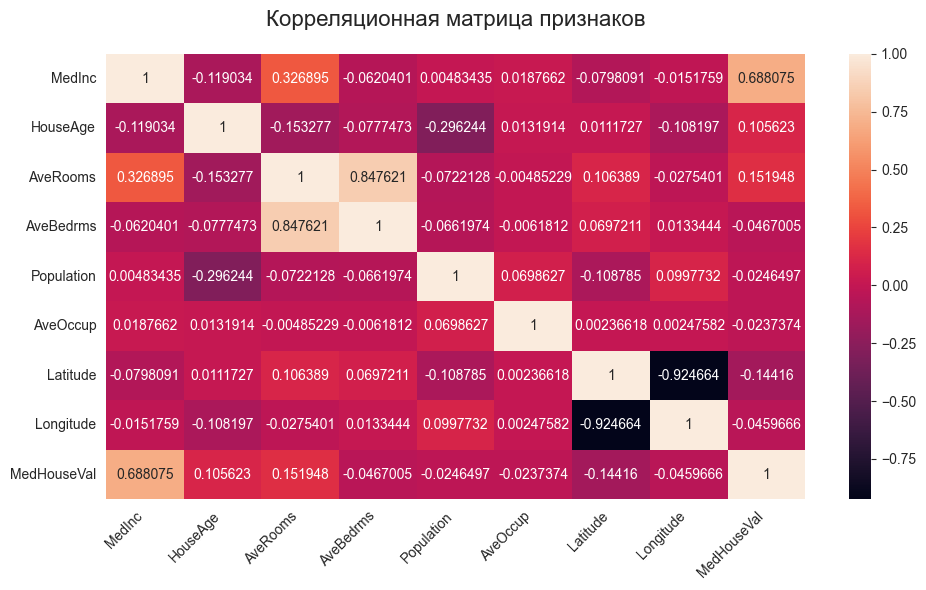

In [20]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt="g")
plt.title("Корреляционная матрица признаков", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Относительно сильная корреляция между AevRooms и AveBedrooms - уберем AveBedrooms и пересчитаем показатели. Так же сильная корреляция между целевой переменной и медианным доходом, но в данном случае мы ее оставим, потому что это корреляция между признаками. AveBedrms - удаление этого коррелирующего признака немного улучшило качество модели по сравнению с базовой моделью.

In [21]:
X_1 = X.copy()

X_1 = X_1.drop(columns=["AveBedrms"])

metrics = get_metrics(X_1, y)
print(metrics["rmse"])
print(metrics["r2"])

0.7398151789804085
0.5823239094526443


Исследуйте оставленные признаки на выбросы. Посмотрим в масштабе на все признаки, чтобы понять какие из них детально можно разобрать на выбросы.

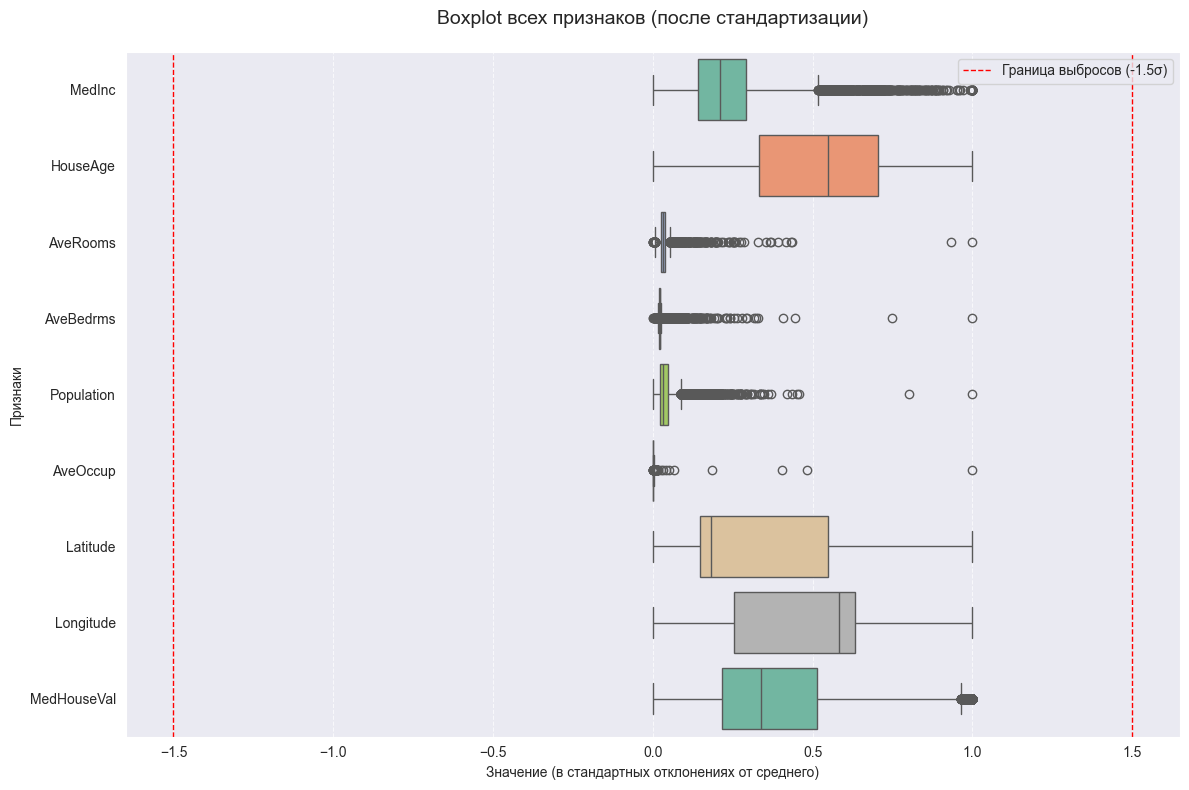

In [22]:
from sklearn.preprocessing import MinMaxScaler

numeric_cols = df.select_dtypes(include=["number"]).columns

df_scaled_mm = df[numeric_cols].copy()
scaler_mm = MinMaxScaler()
df_scaled_mm[numeric_cols] = scaler_mm.fit_transform(df_scaled_mm)

n_features = len(numeric_cols)
fig_height = max(8, n_features * 0.35)

plt.figure(figsize=(12, fig_height))
sns.boxplot(data=df_scaled_mm, orient="h", palette="Set2")
plt.title("Boxplot всех признаков (после стандартизации)", fontsize=14, pad=20)
plt.xlabel("Значение (в стандартных отклонениях от среднего)")
plt.ylabel("Признаки")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.axvline(
    -1.5, color="red", linestyle="--", linewidth=1, label="Граница выбросов (-1.5σ)"
)
plt.axvline(1.5, color="red", linestyle="--", linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

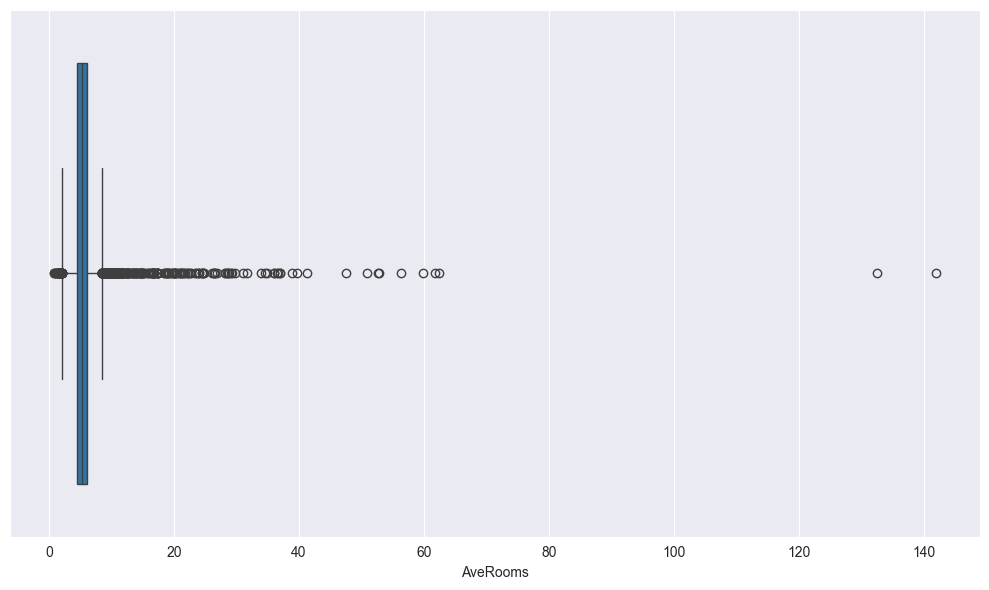

In [23]:
df_1 = df.copy()
df_1 = df_1[(df_1["AveOccup"] < 4.5)]

X_2 = df_1.drop(columns=["MedHouseVal"])
y_2 = df_1["MedHouseVal"]

plt.figure(figsize=(10, 6))
sns.boxplot(x=X_2["AveRooms"])
plt.tight_layout()
plt.show()

Поисследовав удаление выбросов - имеет смысл удалить часть выбросов AveOccup, так как это ведет к снижению RMSE и увеличению R2. Удаление выбросов других признаков увеличивает RMSE, поэтому мы их удалять не будем.

In [24]:
metrics = get_metrics(X_2, y_2)
print(metrics["rmse"])
print(metrics["r2"])

0.6555426743756605
0.6919686845954827


Измените несколько признаков на выбор математически. Например, вычислите логарифм, возведите в квадрат, извлеките квадратный корень.

In [25]:
df_3 = df.copy()
df_3 = df_3[(df_3["AveOccup"] < 4.5)]

features_to_trans = ["AveOccup", "AveBedrms", "MedInc"]

trans_methods = {"log": np.log, "sqrt": np.sqrt, "square": np.square}

for feature in features_to_trans:
    for name, method in trans_methods.items():
        col_name = f"{feature}_{name}"
        df_3[col_name] = method(df_3[feature])

df_3.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,AveOccup_log,AveOccup_sqrt,AveOccup_square,AveBedrms_log,AveBedrms_sqrt,AveBedrms_square,MedInc_log,MedInc_sqrt,MedInc_square
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0.938270,1.598611,6.530864,0.023530,1.011835,1.048186,2.119287,2.885342,69.308955
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0.746613,1.452529,4.451433,-0.028522,0.985840,0.944552,2.116424,2.881215,68.913242
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,1.030426,1.673995,7.852660,0.070874,1.036073,1.152287,1.982022,2.693956,52.669855
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0.935287,1.596228,6.492025,0.070514,1.035886,1.151456,1.730434,2.375521,31.844578
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0.779998,1.476979,4.758799,0.077962,1.039750,1.168736,1.347086,1.961173,14.793254


In [26]:
X_3 = df_3.drop(columns=["MedHouseVal"])
y_3 = df_3["MedHouseVal"]

metrics = get_metrics(X_3, y_3)
print(metrics["rmse"])
print(metrics["r2"])

0.6358805807891804
0.7101695188542549


Добавление новых преобразованных признаков помогло еще улучшить качество модели.